In [1]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sp_minimized = openmc.StatePoint('./most_minimized_ppf/statepoint.80.h5')

In [3]:
sp_p1c_shape = openmc.StatePoint('./p1c_shape/statepoint.80.h5')

In [4]:
def get_ppf_fuel(sp, pf_z):
    mesh_tally = sp.get_tally(name='fqr')
    fqro = mesh_tally.get_slice(scores=['fission-q-recoverable'])
    nu_fission = mesh_tally.get_slice(scores=['nu-fission'])
    fission = mesh_tally.get_slice(scores=['fission'])
    fqro_list = fqro.mean
    fqro_list.shape = (5,10)
    fqro_array = np.array(fqro_list)
    pf = [pf_z] * 5
    pf_array = np.array(pf_z)
    ppf = np.max((fqro_array/ pf_array))/ np.mean(fqro_array/ pf_array)
    return ppf

In [5]:
# sp_minimized PPF = 1.047
get_ppf_fuel(sp_minimized,[0.03337463, 0.03131802, 0.02472686, 0.0248056,
 0.03142039, 0.03332661, 0.02728383, 0.0235643,
 0.02849093, 0.03368883])

1.0476006433563791

In [6]:
get_ppf_fuel(sp_p1c_shape, [0.0351021, 0.03688184, 0.03226389, 0.02426826, 
                            0.01812387, 0.01784898, 0.02362336, 0.03167073, 
                            0.03672833, 0.03548863])

1.1278138773892117

In [7]:
def flux_total(sp):
    tally_flux_all = sp.get_tally(name='flux_all')
    flux_all = tally_flux_all.get_slice(scores=['flux'])
    nu_fission_all = tally_flux_all.get_slice(scores=['nu-fission'])
    fission_all = tally_flux_all.get_slice(scores=['fission'])
    nu = sum(nu_fission_all.mean) / sum(fission_all.mean)
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * 1 / (100 * 20)
    k = sp.k_combined.n
    P = 1456
    N = P * nu / (Q * k)
    flux_all_vals = flux_all.mean * 1 / V * N
    flux_all_vals.shape = (20, 100)
    return flux_all_vals

(520000000000000.0, 580000000000000.0)

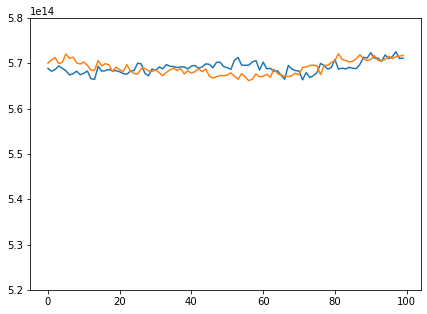

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(flux_total(sp_p1c_shape)[10])
ax.plot(flux_total(sp_minimized)[10])
ax.set_ylim(5.2e14, 5.8e14)

In [9]:
flux_total_minimized = flux_total(sp_minimized)
flux_total_p1c = flux_total(sp_p1c_shape)

In [10]:
print(np.amax(flux_total_minimized)/np.amin(flux_total_minimized))
print(np.amax(flux_total_p1c)/np.amin(flux_total_p1c))

1.0172817083591872
1.0143057827727786


In [11]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu, fiss_eg = {}, {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg[x] = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg.mean) / sum(fiss_eg[x].mean)
    return flux_eg, nu, fiss_eg

In [12]:
def get_flux_dict_plank(k, P, z_thickness, nu, flux_eg):
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * z_thickness / (100 * 20)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (20, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [13]:
flux_eg_minimized, nu_minimized, fiss_eg_minimized = get_values(sp_minimized)

0
1
2
3


In [14]:
flux_eg_p1c_shape, nu_p1c_shape, fiss_eg_p1c_shape = get_values(sp_p1c_shape)

0
1
2
3


In [15]:
power_moltres = 1456 # 1cm thick
flux_vals_p1c_shape = get_flux_dict_plank(sp_p1c_shape.k_combined.n, power_moltres, z_thickness=1, nu=nu_p1c_shape, flux_eg=flux_eg_p1c_shape)
flux_vals_minimized = get_flux_dict_plank(sp_minimized.k_combined.n, power_moltres, z_thickness=1, nu=nu_minimized, flux_eg=flux_eg_minimized)



In [16]:
def plot_flux(group, bot, top):
    x = np.arange(0, 27.1, 27.1/100)
    flux_minimized = np.array(flux_vals_minimized['eg'+str(group)][10])
    import scipy
    print('kuro minimized',scipy.stats.kurtosis(flux_minimized))
    flux_p1c_shape = np.array(flux_vals_p1c_shape['eg'+str(group)][10])
    print('kuro p1c', scipy.stats.kurtosis(flux_p1c_shape))
    p1c_shape_max_min = max(flux_vals_p1c_shape['eg'+str(group)][10]) / min(flux_vals_p1c_shape['eg'+str(group)][10])
    minimized_max_min = max((flux_vals_minimized['eg'+str(group)][10]))/ min((flux_vals_minimized['eg'+str(group)][10]))
    print("minimized", minimized_max_min)
    print("p1c shape", p1c_shape_max_min)
    print("minimized/p1c_shape", minimized_max_min/p1c_shape_max_min)
    print("%", (minimized_max_min-p1c_shape_max_min)/p1c_shape_max_min*100)
    fig, ax = plt.subplots(figsize=(11,7))
    ax.plot(x, flux_p1c_shape, label="p1c shape distribution")
    ax.plot(x, flux_minimized, label=r'simulation p-2b: most-minimized $PPF_{fuel}$ distribution')
    ax.set_ylim(bot, top)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('x [cm]', fontsize=20)
    ax.set_ylabel(r'Flux [$n \cdot cm{-^2}s^{-1}$]', fontsize=20)
    ax.set_title("Group "+str(group), fontsize=24)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.grid()
    ax.set_xlim(0, 27.1)
    plt.savefig("flux-comparison-0.0292-plank_grp"+str(group)+".png",bbox_inches='tight')

In [17]:
def plot_flux2(group, bot, top):
    x = np.arange(0, 27.1, 27.1/100)
    flux_minimized = np.array(flux_vals_minimized['eg'+str(group)])
    flux_p1c_shape = np.array(flux_vals_p1c_shape['eg'+str(group)])
    p1c_shape_max_min = np.amax(flux_vals_p1c_shape['eg'+str(group)]) / np.amin(flux_vals_p1c_shape['eg'+str(group)])
    minimized_max_min = np.amax((flux_vals_minimized['eg'+str(group)]))/ np.amin((flux_vals_minimized['eg'+str(group)]))
    print("minimized", minimized_max_min)
    print("p1c shape", p1c_shape_max_min)
    print("minimized/p1c_shape", minimized_max_min/p1c_shape_max_min)
    print("%", (minimized_max_min-p1c_shape_max_min)/p1c_shape_max_min*100)
    fig, ax = plt.subplots(figsize=(11,7))
    ax.plot(x, flux_p1c_shape[10], label="p1c shape distribution")
    ax.plot(x, flux_minimized[10], label=r'simulation p-2b: most-minimized $PPF_{fuel}$ distribution')
    ax.set_ylim(bot, top)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('x [cm]', fontsize=20)
    ax.set_ylabel(r'Flux [$n \cdot cm{-^2}s^{-1}$]', fontsize=20)
    ax.set_title("Group "+str(group), fontsize=24)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.grid()
    ax.set_xlim(0, 27.1)
    plt.savefig("flux-comparison-0.0292-plank_grp"+str(group)+".png",bbox_inches='tight')

kuro minimized -0.256737190630667
kuro p1c 0.2745642271258921
minimized 1.1373626281097269
p1c shape 1.1037749294499895
minimized/p1c_shape 1.0304298437693944
% 3.042984376939433


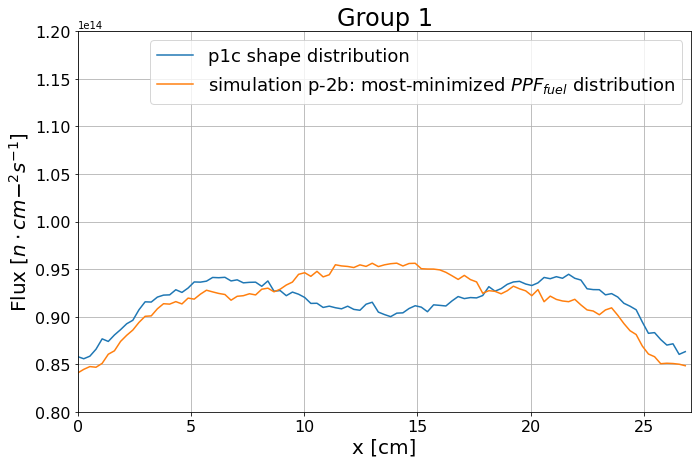

In [18]:
plot_flux(1, 0.8e14, 1.2e14)

minimized 1.14397699667188
p1c shape 1.1155291409252757
minimized/p1c_shape 1.0255016697484105
% 2.550166974841041


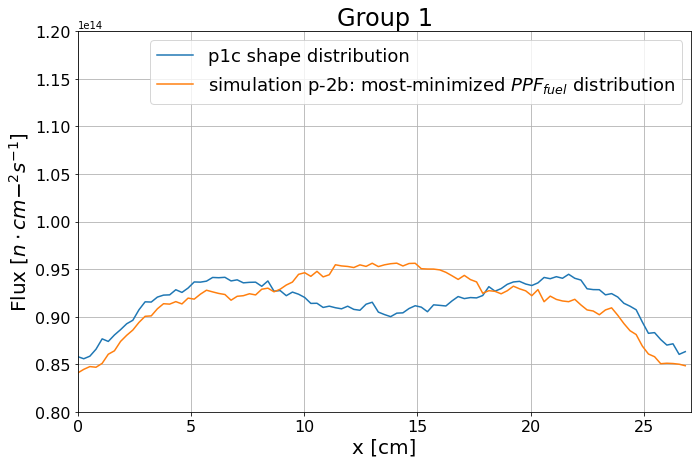

In [19]:
plot_flux2(1, 0.8e14, 1.2e14)

kuro minimized 0.0993665861892512
kuro p1c -0.8596294113943874
minimized 1.0253927261925515
p1c shape 1.0254300126222529
minimized/p1c_shape 0.9999636382500586
% -0.0036361749941378856


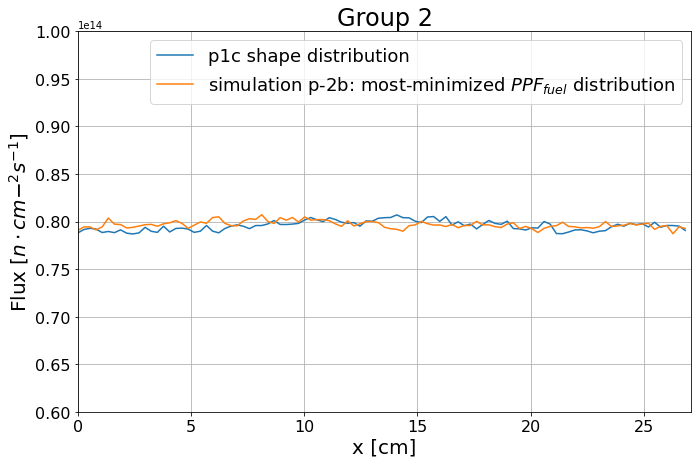

In [20]:
plot_flux(2, 0.6e14, 1e14)

minimized 1.030300763730376
p1c shape 1.035232822829982
minimized/p1c_shape 0.9952357972131105
% -0.47642027868894515


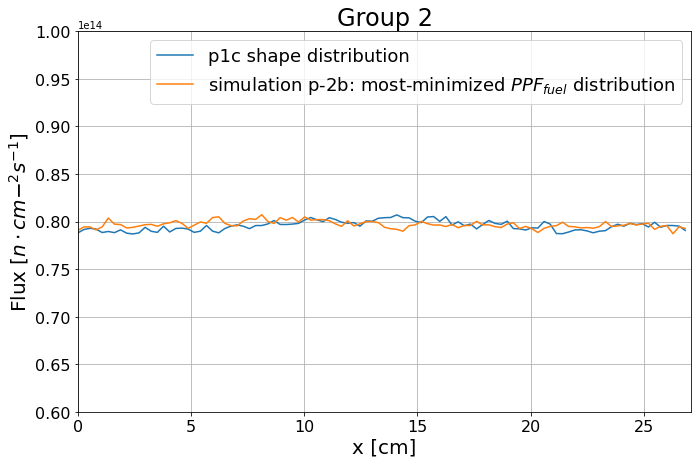

In [21]:
plot_flux2(2, 0.6e14, 1e14)

kuro minimized -0.03413005937642222
kuro p1c 0.08064377855780114
minimized 1.0574033177717779
p1c shape 1.0423930694388541
minimized/p1c_shape 1.0143997967494203
% 1.4399796749420193


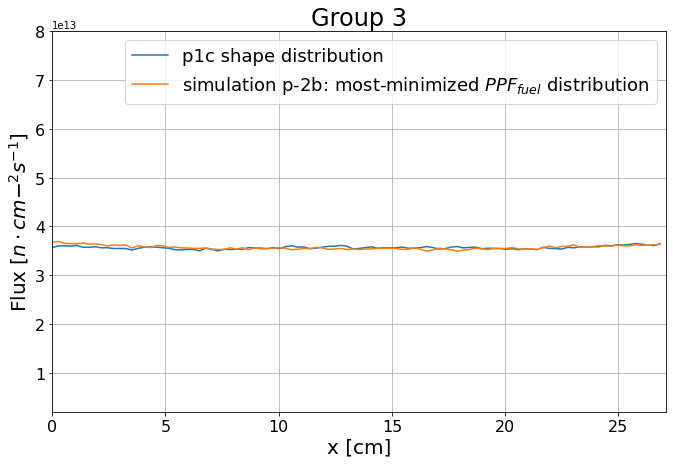

In [22]:
plot_flux(3, 0.2e13, 0.8e14)

kuro minimized -0.7196006388356997
kuro p1c 0.45275758340176253
minimized 1.0420959694584286
p1c shape 1.0310698681845285
minimized/p1c_shape 1.0106938449217941
% 1.06938449217942


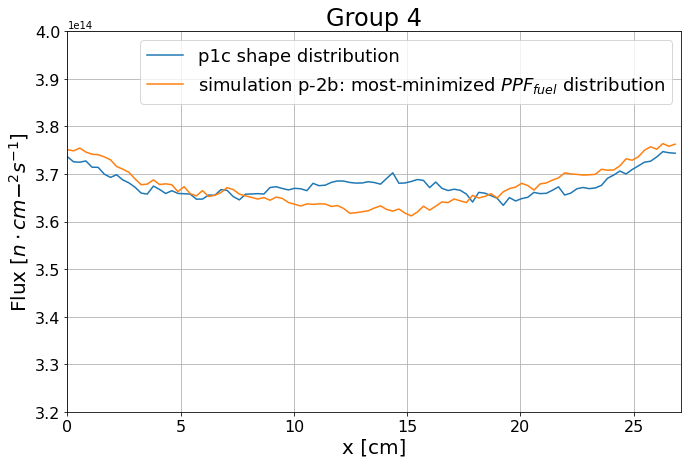

In [23]:
plot_flux(4, 3.2e14, 4e14)
# self shielding is equivalent 

In [24]:
# in group 4, the most-minimized ppf distribution is 1.06% flatter than the 
# p1c shape distribution, resulting in lower PPF fuel. 
# As demonstrated before, a triso distribution that flattens 
# thermal flux distr results in lower PPF fuel... 

minimized 1.0494599105289495
p1c shape 1.0347876983817368
minimized/p1c_shape 1.0141789588049395
% 1.41789588049394


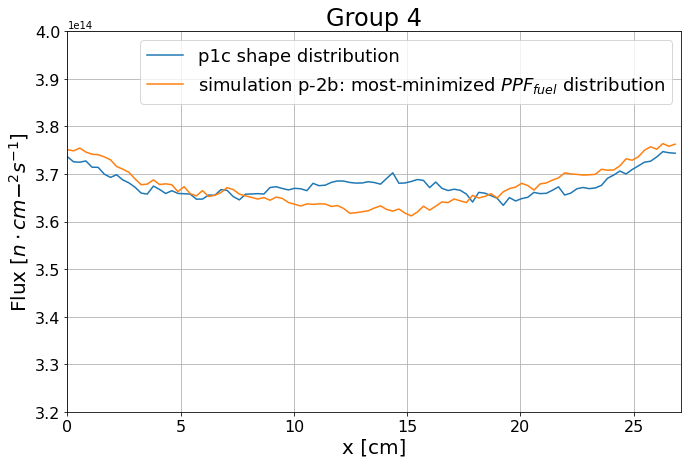

In [25]:
plot_flux2(4, 3.2e14, 4e14)
# self shielding is equivalent 